In [78]:
%pip install pandas matplotlib numpy boto3 secure-smtplib 
%pip install scikit-learn ai-core-sdk hdbcli hana_ml 

  Obtaining dependency information for hana_ml from https://files.pythonhosted.org/packages/ad/95/b12efe660fd442638f262b288302f3074e3c9ed99986b5d664449064f879/hana_ml-2.18.23092701-py3-none-any.whl.metadata
  Using cached pydotplus-2.0.2-py3-none-any.whl
  Obtaining dependency information for Deprecated from https://files.pythonhosted.org/packages/20/8d/778b7d51b981a96554f29136cd59ca7880bf58094338085bcf2a979a0e6a/Deprecated-1.2.14-py2.py3-none-any.whl.metadata
  Using cached Deprecated-1.2.14-py2.py3-none-any.whl.metadata (5.4 kB)
  Using cached htmlmin-0.1.12-py3-none-any.whl
  Obtaining dependency information for tqdm>=4.43.0 from https://files.pythonhosted.org/packages/00/e5/f12a80907d0884e6dff9c16d0c0114d81b8cd07dc3ae54c5e962cc83037e/tqdm-4.66.1-py3-none-any.whl.metadata
  Using cached tqdm-4.66.1-py3-none-any.whl.metadata (57 kB)
  Obtaining dependency information for schedule from https://files.pythonhosted.org/packages/f0/1a/e5a65c08d708ee4c002f3f938ba69b2282af478755700c40f037ea

In [80]:
import os
import requests, json
import pandas as pd
from datetime import date,datetime
import numpy as np
import boto3
from io import StringIO  # Required for reading/writing data as strings

from ai_api_client_sdk.ai_api_v2_client import AIAPIV2Client
from sklearn.metrics import mean_squared_error, r2_score
from hdbcli import dbapi
import hana_ml.dataframe as dataframe

import smtplib
from email.mime.text import MIMEText

In [6]:
today = date.today()
today_yyyymmdd = today.strftime("%Y%m%d")
today_dataset = f'pipeline_corrosion_{today_yyyymmdd}.csv'

['2023-09-21']

In [93]:
resource_group = 'dev'

aic_service_key = "aic_service_key.json" # ENSURE YOU HAVE THE FILE PLACED CORRECTLY
with open(aic_service_key) as ask:
    aic_sk = json.load(ask)

ai_api_client = AIAPIV2Client(
    base_url=aic_sk["serviceurls"]["AI_API_URL"] + "/v2/lm",
    auth_url=aic_sk["url"] + "/oauth/token",
    client_id=aic_sk['clientid'],
    client_secret=aic_sk['clientsecret'],
    resource_group=resource_group)

In [94]:
# Preparing the input for inference
# todo: get the latest running deployment filter by configuration pipeline-corr-serving-conf
#deployment_list = ai_api_client.deployment.get()
#deployment_list

deployment = ai_api_client.deployment.get('d70167c5c9b5d723')
endpoint = f"{deployment.deployment_url}/v2/predict"
print(endpoint)

headers = {
        "Authorization": ai_api_client.rest_client.get_token(),
        'ai-resource-group': resource_group,
        "Content-Type": "application/json"}

https://api.ai.prod.eu-central-1.aws.ml.hana.ondemand.com/v2/inference/deployments/d70167c5c9b5d723/v2/predict


In [4]:
#let's start with test the pipeline corrosion prediction model against some test data
test_data = {
    "loc_id": 1,
    "idx": 1,
    "v01": 46.33258406509145,
    "v02": 0.1303680944841564,
    "v03": 7.662771868299977,
    "v04": 34.488998349986666,
    "v05": 3184.9007294366934,
    "v06": 0.42151431187726046,
    "v07": 8.603346447810724,
    "v08": 685.903760553736,
    "v09": 1278.1438211804366,
    "v10": 1.1728402720704079,
    "v11": 2423.608241321227,
    "v12": 886.6780900501889,
    "v13": 1.1191012153360598
}

response = requests.post(endpoint, headers=headers, json=test_data)
print('Inference result:', response.json())

Inference result: [-0.02421947]


In [ ]:
########################################################################
# Step 1: Read the incoming data of pipeline corrosion from AWS S3
# Input Parameters: 
#   dataset_file_name(csv) - The given file name of incoming dataset in s3
# Return:  
#   df - The dataframe of the given incoming dataset
########################################################################
def read_incoming_data_in_s3(dataset_file_name):
    print('Step 1: Read the incoming data of pipeline corrosion from AWS S3')

    # Initialize an S3 client
    s3 = boto3.client('s3')

    # Specify your AWS S3 bucket and file names
    bucket_name = 'ai-sustainability-dataset'
    incoming_dataset = f'pipeline-corrosion/data/incoming/{dataset_file_name}'

    # Read the CSV file from S3 into a DataFrame
    response = s3.get_object(Bucket=bucket_name, Key=incoming_dataset)
    data = response['Body'].read().decode('utf-8')
    df = pd.read_csv(StringIO(data))
    print(f'Total {len(df)} records read from {dataset_file_name}')

    return df

In [137]:
########################################################################
# Step 2: Perform test of incoming data against pipeline corrosion 
# prediction model. And calculate the metrics(mse and r2 score) of the test
# Input Parameters: 
#   df - The dataframe of the incoming dataset in s3
#   dataset_file_name(csv) - The given file name of incoming dataset in s3
# Return:  
#   df - column pre_corr-dept(the predicted corrosion depth) added to 
#   the original df
########################################################################
def perform_test(df, dataset_file_name):
    print('Step 2: Perform test of incoming data against pipeline corrosion prediction model.')
    X = df.drop(['corr_depth','date'], axis=1)
    def apply_request(row):
            response = requests.post(endpoint, headers=headers, json=row.to_dict())
            index = int(row['loc_id'])
            if index % 10 == 0:
                print(f'{index} records proceeded...')
            return response.json()[0]
    
    df['pred_corr_depth'] = X.apply(apply_request, axis=1)
    
    print('Calculating the performance metrics.')
    mse = mean_squared_error(df['corr_depth'],  df['pred_corr_depth'])
    r2 = r2_score(df['corr_depth'],  df['pred_corr_depth'])
    print(f'MSE of continuous monitoring model performance on {dataset_file_name}: {mse}')
    print(f'R2 Score of continuous monitoring model performance on {dataset_file_name}: {r2}')

    return df, mse, r2

In [118]:
########################################################################
# Step 3: Calculate the top n records contributing most to MSE
# Input Parameters: 
#   df_result - The result dataframe of step 2
#   top_n - The desired top count of top mse contributors. default as 10
# Return:  
#   df_result - columns residuals(the square of variance between corr_dept
#   and pred_corr_depth 
#   mse_top_records - the dataframe of top mse contributors for the report
########################################################################
def calc_top_mse_contributors(df_result, top_n=10):
    print('Step 3: Calculate the top n records contributing most to MSE')
    
    # Calculate residuals
    df_result['residuals'] = (df_result["corr_depth"] - df_result['pred_corr_depth']) ** 2
    
    # Create a DataFrame to store residuals along with the original data
    results = pd.DataFrame()
    results['loc_id'] = df_result['loc_id'] 
    results['corr_depth'] = df_result["corr_depth"]
    results['pred_corr_depth'] = df_result['pred_corr_depth']
    results['residuals'] = df_result['residuals'] 

    # Sort by squared residuals in descending order
    mse_sorted_results = results.sort_values(by='residuals', ascending=False)

    # Get the top 10 records with the largest squared residuals
    mse_top_records = mse_sorted_results.head(top_n)

    # Print or inspect these top 10 records
    print(f'The top {top_n} location id contribute the most of MSE:')
    print(mse_top_records)

    return df_result, mse_top_records

In [68]:
########################################################################
# Step 4: Save the metrics to SAP Dataspere
# As of current version, the metrics is saved to the open schema of
# SAP Dataspere via direct DML. The better option should be using 
# HDI container inside SAP Dataspere
#
# Input Parameters: 
#   idx - The id index of the record as an integer representation of date
#   for GradientBoosting model of pipeline corrosion prediction.
#   date - The target date which decide its associated dataset.
#   mse - The mean square value of the test, result from step 2
#
# Return:  
#   df_result - columns residuals(the square of variance between corr_dept
#   and pred_corr_depth 
#   mse_top_records - the dataframe of top mse contributors for the report
########################################################################
def save_metrics_to_hcs(idx, date, mse) -> None:
    print('Step 4: Save the metrics to SAP Dataspere')

    hana_host = os.getenv("HANA_HOST")
    hana_port = int(os.getenv("HANA_PORT", 443))
    hana_user = os.getenv("HANA_USER")
    hana_password = os.getenv("HANA_PASSWORD")
    conn = dbapi.connect(
    address=hana_host,
    port=hana_port,
    user=hana_user,
    password=hana_password)
    cursor = conn.cursor()

    sql = 'UPSERT PIPELINECORROSION#SA_PIPE_CORR.pipe_dataset_for_sac_mse (idx, date, mse) VALUES (?, ?, ?) WHERE idx =?'
    cursor = conn.cursor()
    cursor.execute(sql, (idx, date, mse, idx))
    cursor.close()
    conn.close()
    print(f'Metrics record {idx}, {date}, {mse} saved to SAP Dataspere')

In [62]:
save_metrics_to_hcs(131, '2023-10-15', 5.799360795178701)

MSE record 131, 2023-10-15, 5.799360795178701 saved to SAP Dataspere


In [112]:
########################################################################
# Send an email function via smtp
#
# Input Parameters: 
#   subject - subject of email
#   body - message body of email
#   sender - sender's email
#   recipients - the list of recipients
########################################################################
def send_email(subject, body, sender, recipients, password) -> None:
    msg = MIMEText(body)
    msg['Subject'] = subject
    msg['From'] = sender
    msg['To'] = ', '.join(recipients)
    with smtplib.SMTP_SSL('smtp.gmail.com', 465) as smtp_server:
       smtp_server.login(sender, password)
       smtp_server.sendmail(sender, recipients, msg.as_string())
    print("Message sent!")

In [ ]:
########################################################################
# Step 5: Send the continuous monitoring report to MLops team via email
#
# Input Parameters: 
#   df - the dataframe of step 3
#   mse - the mean square error of the test in step 2
#   r2 - the r2 score of the test in step 2
#   top_mse_records - the list of top mse contributors in step 4
#   dataset_file_name - the given file of incoming dataset
########################################################################
def send_report(df, mse, r2, top_mse_records, dataset_file_name):
    print('Step 5: Send the continuous monitoring result to MLops team via email')
    mse_threshold = 0.2
    r2_score_threshold = 0.5
    subject = "Continuous Monitoring Report of Pipeline Corrosion ML Model"
    body = f"Dear MLOps Team, Good day.\n\nContinuous Monitoring Pipeline has been successfully executed on {dataset_file_name} at {datetime.now()}.\nHere you have the continuous monitoring report of the Pipeline Corrosion Prediction Model.\nNumber of Total Records: {len(df)}\nMean Square Error: {mse}\nMSE Threshold: {mse_threshold}\nR2 Score: {r2}\nR2 Score Threshold: {r2_score_threshold}\nThe top {top_n} location id contributing to MSE:\n {top_mse_records.to_string(index=False)} \n\nThis is an auto-generated email. Please don't reply.\n\nKind Regards,\nML Operation Team"
    sender = "yatsealee@gmail.com"
    recipients = ["yatsealee@gmail.com"]
    password = "hmrsjfdsnmsuamju"
    send_email(subject, body, sender, recipients, password)

In [121]:
########################################################################
# Step 6: Save the prediction result and residuals from the working dataframe 
# back to the dataset in S3
#
# Input Parameters: 
#   df - the working dataframe from step 3
#   dataset_file_name - The original incoming dataset
########################################################################
def save_pred_to_s3_dataset(df, dataset_file_name):
    print('Step 6: Save the prediction result back to the dataset in S3')
    s3 = boto3.client('s3')
    csv_buffer = StringIO()
    df.to_csv(csv_buffer, index=False)
    csv_data = csv_buffer.getvalue()

    # Specify AWS S3 bucket and file names
    bucket_name = 'ai-sustainability-dataset'
    incoming_dataset = f'pipeline-corrosion/data/incoming/{dataset_file_name}'

    # Put the modified data (CSV string) to the dataset in AWS S3
    s3.put_object(Bucket=bucket_name, Key=incoming_dataset, Body=csv_data)
    print(f"Prediction data written to '{incoming_dataset}' in S3.")

In [133]:
########################################################################
# The facade function to orchestrate the whole process of continuous 
# monitoring
#
# Input Parameters: 
#   date_str - the date string in yyyy-mm-dd format to run the monitoring
#   default as today
########################################################################
def continuous_monitoring2(date_str = date.today().strftime('%Y%m%d')):
    # Step 1: Read the incoming dataset in AWS S3
    dataset_file_name = f"pipeline_corrosion_{date_str.replace('-','')}.csv"
    df = read_incoming_data_in_s3(dataset_file_name)

    # Step 2: Test the dataset on the current active model.
    df, mse, r2 = perform_test(df, dataset_file_name)
    
    # Step 3: Calculate the top MSE contributors 
    df, top_mse_contributers = calc_top_mse_contributors(df)

    # Step 4: Save the metrics of testing into SAP Dataspere
    idx =  int(df.loc[0, 'idx'])
    save_metrics_to_hcs(idx, date_str, mse)

    # Step 5: Notify the MLOp team about the test result via email.
    send_report(df, mse, r2, top_mse_contributers, dataset_file_name)

    # Step 6: Optional write back the prediction for each record to the dataset for detail
    # Convert the filtered DataFrame back to CSV format as a string
    save_pred_to_s3_dataset(df, dataset_file_name)

    return df

In [138]:
result_df = continuous_monitoring2('2023-10-15')
result_df

Step 1: Read the incoming data of pipeline corrosion from AWS S3
Total 200 records read from pipeline_corrosion_20231015.csv
Step 2: Perform test of incoming data against pipeline corrosion prediction model.
Calculate the performance metrics.
10 records proceeded...
20 records proceeded...
30 records proceeded...
40 records proceeded...
50 records proceeded...
60 records proceeded...
70 records proceeded...
80 records proceeded...
90 records proceeded...
100 records proceeded...
110 records proceeded...
120 records proceeded...
130 records proceeded...
140 records proceeded...
150 records proceeded...
160 records proceeded...
170 records proceeded...
180 records proceeded...
190 records proceeded...
200 records proceeded...
MSE of continuous monitoring model performance on pipeline_corrosion_20231015.csv: 5.799360795178701
R2 Score of continuous monitoring model performance on pipeline_corrosion_20231015.csv: 0.8130115286540245
Step 3: Calculate the top n records contributing most to M

,loc_id,idx,date,corr_depth,v01,v02,v03,v04,v05,v06,v07,v08,v09,v10,v11,v12,v13,pred_corr_depth,residuals
0,1,131,2023-10-15,0.078562,46.226251,0.130022,7.667412,34.503527,3188.968921,0.420342,8.542704,685.934335,1277.963623,1.180823,2424.300731,889.016702,1.115192,0.149062,0.004970
1,2,131,2023-10-15,0.200906,46.399864,0.130073,7.642894,34.389957,3182.628347,0.421635,8.602152,690.016279,1273.342641,1.170531,2419.617794,887.465525,1.118597,0.160205,0.001657
2,3,131,2023-10-15,0.087764,46.344463,0.130327,7.654108,34.523613,3171.012570,0.422372,8.556702,685.141887,1275.287453,1.175542,2428.320266,881.119498,1.110798,0.142749,0.003023
3,4,131,2023-10-15,0.361799,46.115259,0.130224,7.625571,34.565669,3184.005297,0.423439,8.547079,684.597970,1275.705962,1.174210,2416.944017,884.641117,1.121099,0.176329,0.034399
4,5,131,2023-10-15,0.213919,46.149182,0.130378,7.650592,34.616128,3195.795755,0.421721,8.599037,689.518661,1278.848009,1.177744,2424.911697,882.244979,1.113069,0.171890,0.001766
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,196,131,2023-10-15,19.002512,46.887423,0.157168,8.185420,40.517470,3486.610590,0.424927,9.909976,775.800083,1559.946571,1.446663,2676.289585,892.392662,1.201457,12.037731,48.508166
196,197,131,2023-10-15,10.471684,57.472654,0.154997,8.481928,36.367633,3552.018893,0.431624,8.593890,728.067612,1458.577421,1.402843,2464.733463,948.792569,1.310748,7.378388,9.568479
197,198,131,2023-10-15,8.993468,56.866087,0.160842,7.651763,37.723772,3402.403381,0.482277,9.901724,767.561674,1553.561395,1.214131,2969.472526,1044.183236,1.294577,2.736190,39.153531
198,199,131,2023-10-15,4.693473,47.981234,0.160436,9.066956,39.302078,3427.760963,0.475390,9.505734,695.259269,1412.955921,1.377995,2843.240794,964.180543,1.248121,3.639826,1.110173


todo: plot the result


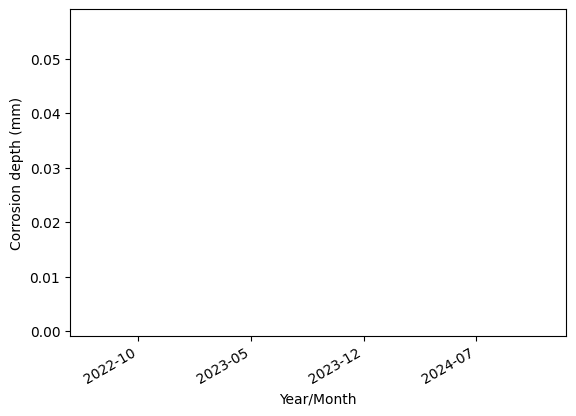

In [58]:
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=210))
plt.plot(pd.to_datetime(test_low_loc1.date), test_low_loc1.corr_depth)
plt.plot(pd.to_datetime(test_mod_loc51.date), test_mod_loc51.corr_depth)
plt.plot(pd.to_datetime(test_hig_loc101.date), test_hig_loc101.corr_depth)
plt.plot(pd.to_datetime(test_sev_loc151.date), test_sev_loc151.corr_depth)
plt.xlabel('Year/Month', fontsize=10)
plt.ylabel('Corrosion depth (mm)', fontsize=10)
plt.gcf().autofmt_xdate()
plt.show()